In [17]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Project Description

This notebook uses a kaggle dataset from 2023 containing data on the characteristics of the top 1000 songs on spotify.

We also use a dataset containing over 1 million songs to compare the popular songs to a more "typical" spotify song.

## Research Questions
* How does the danceability of a song affect its popularity?
* How have trends in danceability changed over time?

In [18]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Import CSV's

In [19]:
# Spotify Top Songs 2023.
spotify = pd.read_csv("spotify-2023.csv", encoding = "latin-1")

# Remove 574 (BAD ROW).
spotify = spotify.drop(spotify.index[574])

# Make streams into integers.
spotify["streams"] = spotify["streams"].apply(int)

In [20]:
# Spotify 1.2 Million Songs.
spotify_1M = pd.read_csv("tracks_features.csv")

# Remove year 0 songs (That's a nonsense point and I can't be bothered to find out when each of them were released).
mask = (spotify_1M["year"] != 0)
spotify_1M = spotify_1M[mask]

# Transform percentages from [0,1] to [0, 100].
percentage_columns = ["speechiness", "acousticness", "instrumentalness", "liveness", "valence", "danceability", "energy"]
for col in percentage_columns:
    spotify_1M.loc[:, col] = spotify_1M.loc[:, col].apply(lambda x: 100 * x)

# Histogram of Popular Songs vs All Songs

IMPORTANT: Plotly.go generates a plot with a large file size, which isn't an issue when the plot is screenshotted, but is an issue when trying to host this notebook on github. To save on file size, this chart is not displayed here, but a screenshot of it is included instead.

In [ ]:
# Histogram of popular songs overlayed with histogram of all songs on spotify.
fig = go.Figure()
# Popular songs.
fig.add_trace(go.Histogram(x = spotify.loc[:, "danceability_%"],
                        nbinsx = 100,
                        histnorm = "probability",
                        name = "Top 1k Songs"
                    ))
# Histogram of All songs.
fig.add_trace(go.Histogram(x = spotify_1M.loc[:, "danceability"],
                        nbinsx = 100,
                        histnorm = "probability",
                        name = "General Sample of Songs"
                    ))
# Titles and axes.
fig.update_layout(barmode = "overlay", 
                  xaxis_title = "Danceability (%)",
                  yaxis_title= "Frequency of Danceability",
                  title = "Danceability of Top 1k Songs vs Danceability of Songs Overall",
                  width = 700,
                  height = 400
                )

# make see-through
fig.update_traces(opacity = 0.60)

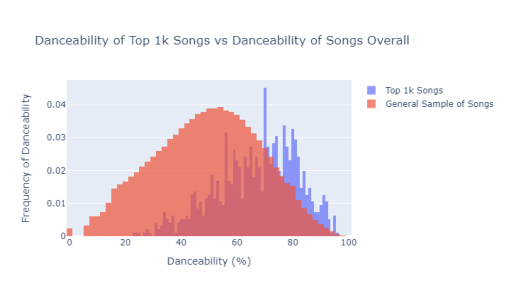

In [30]:
# display saved image of the plot
plot = plt.imread("Visualizations/Danceability of Top 1k Songs vs Danceability of General Songs.png")
plt.axis('off')
plt.imshow(plot)

In [22]:
# Get data from histogram.
spotify_counts, bins = np.histogram(spotify.loc[:,"danceability_%"].apply(float), bins = range(0,100,1)) # pull data for popular songs
print(spotify_counts)
spotify_counts = spotify_counts / spotify_counts.sum() # normalize distribution for popular songs
spotify_1M_counts, bins = np.histogram(spotify_1M.loc[:,"danceability"], bins = range(0,100,1)) # pull data for all songs
spotify_1M_counts = spotify_1M_counts / spotify_1M_counts.sum() # normalize distribution for all songs
bins = np.asarray(np.linspace(1,99, num = 99)) # create our own bins, 1-100

## Put histogram data in an array to export as CSV for making the histogram in PowerBI
danceability_histogram = np.asarray([spotify_counts, spotify_1M_counts, bins]).transpose()
pd.DataFrame(danceability_histogram, columns = ["popular", "top1M", "danceability"]).to_csv("danceability_histogram.csv")
print("Histogram data successfully stored")

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  1  1  0  1  2  1  0  4  2  3  7  5  4  6  1  4  5  5  6  5 12 13  8 10
  6 11 12 18 11 16 10  9 30 16 15 25 22 20 11 23 20 26 17 23 20 13 43 26
 21 27 29 19 17 32 26 22 31 28 23 14 19 12 14 10  7  7  9 12 10  5  1  6
  1  0  0]
Histogram data successfully stored


# Distribution of Number of Songs Released Each Year

In [23]:
# dataframe with the mean danceability by year
dance_v_year = spotify_1M.copy(deep = True).loc[:,["year", "danceability"]].groupby("year", as_index = False).mean()
# dataframe with the standard deviation of the danceabiltiy by year
dance_v_year_stdev = spotify_1M.copy(deep = True).loc[:, ["year", "danceability"]].groupby("year", as_index = False).std()

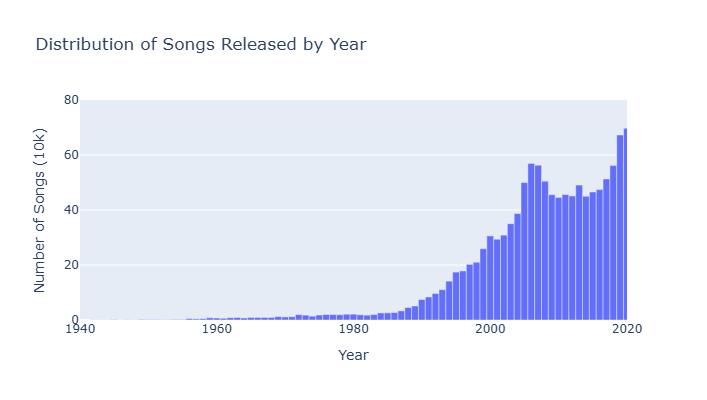

In [24]:
# Histogram of the count of songs by year
fig = go.Figure()
fig.add_trace(go.Bar(x = spotify_1M.loc[:,["year","danceability"]].groupby("year", as_index = False).count().loc[:,"year"], 
                     y = spotify_1M.loc[:,["year","danceability"]].groupby("year", as_index = False).count().loc[:,"danceability"].apply(lambda x : x * 0.001),  
                     name = "Number of Songs From Each Year (10k)",
                    ))
fig.update_layout(barmode = "overlay", 
                  xaxis_title = "Year",
                  yaxis_title= "Number of Songs (10k)",
                  title = "Distribution of Songs Released by Year",
                  yaxis = dict(range = [0, 80]),
                  xaxis = dict(range = [1940, 2020]),
                  bargap = 0,
                  width = 700,
                  height = 400
                )
fig.show()

# Export data for use in Excel.
song_year_count = np.asarray([fig.data[0]["x"], fig.data[0]["y"]])

# Danceability of Songs over Time

This plot illsutrates the mean danceability of songs on Spotify over the course of the last 70 years. It also includes the variance in danceability, shaded in red.

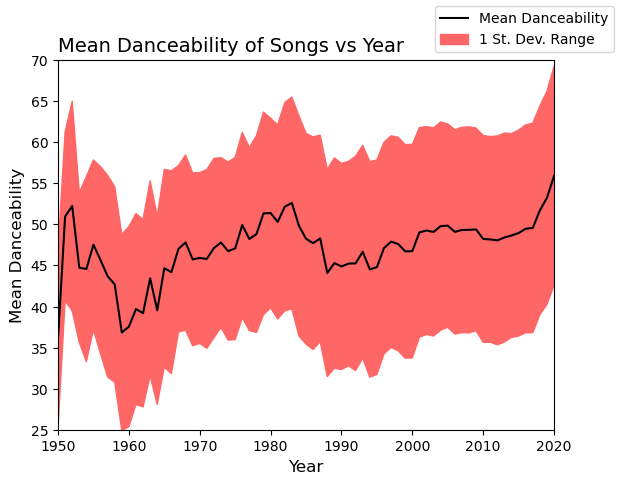

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# get data
error = dance_v_year_stdev["danceability"] * 0.674
x = dance_v_year["year"]
y = dance_v_year["danceability"]

# plot data
plt.plot(x, y, 'k-')
plt.fill_between(x, 
                 y - error, 
                 y + error,
                 color = "#FF6666" )
plt.xlim(1950, 2020)
plt.ylim(25, 70)
plt.xlabel("Year" , size = 12 ) 
plt.ylabel( "Mean Danceability" , size = 12 ) 
plt.title( "Mean Danceability of Songs vs Year" , size = 14, loc = "left") 
plt.figlegend(['Mean Danceability', '1 St. Dev. Range'], loc = "upper right")
plt.show()

# Box Plot of Danceability Over Time

Using box plots to visualize the change over time paints a better picture of the true distribution, but in this case the variance for each year is large enough to obscure trends in the mean value.

In [26]:
# function to bin the data into decades
def bin_year(x):
    for decade in range(1850, 2040, 10):
        if x < decade: return decade - 5

# bin the data
dance_time = spotify_1M.copy(deep = True)
dance_time["year"] = dance_time["year"].apply(bin_year)
dance_time = dance_time.dropna()

# organize into decades
data = []
for decade in pd.Series(dance_time["year"].unique()).sort_values():
    decade_time = dance_time.query("year == @decade")
    data += [decade_time[["danceability"]]]

# plot box plots for each decade
fig = go.Figure()
for i in range(0, pd.Series(dance_time["year"].unique()).sort_values().count()):
    fig.add_trace(go.Box(y = data[0]["danceability"],
                         name = str(pd.Series(dance_time["year"].unique()).sort_values()[i]),
                         boxmean = True, # represent mean
                         marker=dict(color='blue'),  # Set the color explicitly
                         line=dict(color='blue')
                        ))
fig.update_layout(xaxis_title = "Year",
                  yaxis_title= "Danceability",
                  title = "Danceability of Songs Over Time",
                  width = 700,
                  height = 400,
                  showlegend = False
                )
fig.show()